In [1]:
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
!pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 57 kB 3.9 MB/s 
     |████████████████████████████████| 208 kB 17.3 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 51 kB 8.6 MB/s 


In [2]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2021-07-30 11:02:58.150 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-07-30 11:02:58.687 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [3]:
all_images =  Glob('images/training')
all_annots = Glob('annotations_instance/training')

2021-07-30 11:02:58.768 | INFO     | __main__:<module>:1 - 20210 files found at images/training
2021-07-30 11:02:58.819 | INFO     | __main__:<module>:2 - 20210 files found at annotations_instance/training


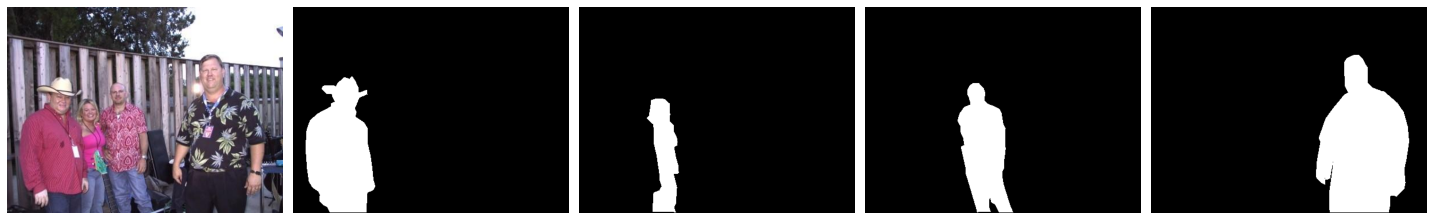

In [4]:

f = 'ADE_train_00014301'

im = read(find(f,all_images),1)
an = read(find(f,all_annots),1).transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4)
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] =g==_id
subplots([im,*masks],sz=20)

In [5]:
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann,1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r):continue
    annots.append(ann)

100%|██████████| 20210/20210 [01:43<00:00, 195.78it/s]


In [6]:
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items ,val_items = train_test_split(_annots,random_state=2)


In [7]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
    

In [8]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]

Tensor	Shape: torch.Size([3, 300, 400])	Min: 0.000	Max: 1.000	Mean: 0.407	dtype: torch.float32
Dict Of 6 items
	BOXES:
	Tensor	Shape: torch.Size([9, 4])	Min: 2.000	Max: 398.000	Mean: 177.444	dtype: torch.float32
	LABELS:
	Tensor	Shape: torch.Size([9])	Min: 1.000	Max: 1.000	Mean: 1.000	dtype: torch.int64
	MASKS:
	Tensor	Shape: torch.Size([9, 300, 400])	Min: 0.000	Max: 1.000	Mean: 0.030	dtype: torch.uint8
	IMAGE_ID:
	Tensor	Shape: torch.Size([1])	Min: 0.000	Max: 0.000	Mean: 0.000	dtype: torch.int64
	AREA:
	Tensor	Shape: torch.Size([9])	Min: 221.000	Max: 17654.000	Mean: 5460.333	dtype: torch.float32
... ... 1 more items


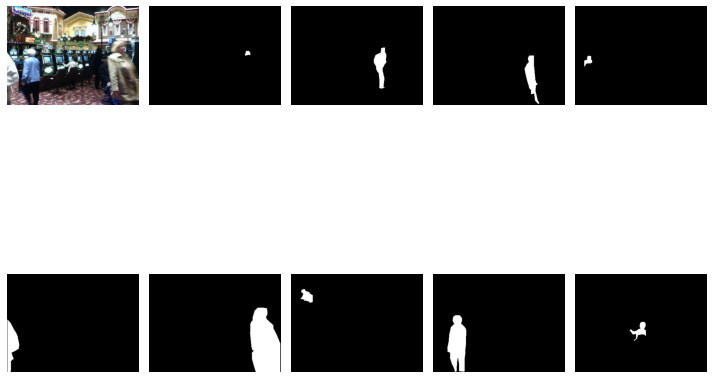

In [9]:
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[0]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)


In [10]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)
    return model

In [11]:
model = get_model_instance_segmentation(2).to(device)
model

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [12]:
dataset = MasksDataset(trn_items,get_transform(train=True),N=3000)
dataset_test = MasksDataset(val_items,get_transform(train=False),N=800)

# define training and validation dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset,batch_size=2,shuffle=True,num_workers=0,collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,batch_size=1,shuffle=False,num_workers=0,
    collate_fn = utils.collate_fn)

In [13]:
num_classes =2 
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,lr=0.005,momentum=0.9,weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

In [14]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [   0/1500]  eta: 0:25:11  lr: 0.000010  loss: 6.4779 (6.4779)  loss_classifier: 0.6828 (0.6828)  loss_box_reg: 0.1933 (0.1933)  loss_mask: 5.5842 (5.5842)  loss_objectness: 0.0108 (0.0108)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 1.0079  data: 0.0367  max mem: 2307
Epoch: [0]  [  10/1500]  eta: 0:16:36  lr: 0.000060  loss: 5.6417 (5.4142)  loss_classifier: 0.5642 (0.5817)  loss_box_reg: 0.2984 (0.3179)  loss_mask: 4.3761 (4.4506)  loss_objectness: 0.0300 (0.0345)  loss_rpn_box_reg: 0.0123 (0.0295)  time: 0.6686  data: 0.0421  max mem: 4056
Epoch: [0]  [  20/1500]  eta: 0:15:54  lr: 0.000110  loss: 3.1711 (3.9873)  loss_classifier: 0.4862 (0.4911)  loss_box_reg: 0.2763 (0.3064)  loss_mask: 2.3853 (3.1366)  loss_objectness: 0.0218 (0.0319)  loss_rpn_box_reg: 0.0093 (0.0214)  time: 0.6269  data: 0.0401  max mem: 4056
Epoch: [0]  [  30/1500]  eta: 0:15:29  lr: 0.000160  loss: 1.5399 (3.1039)  loss_classifier: 0.2861 (0.4101)  loss_box_reg: 0.2551 (0.2935)  loss_mask: 0.8708 (

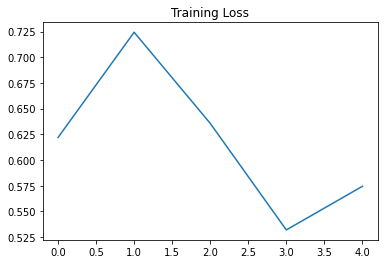

In [15]:
import matplotlib.pyplot as plt
plt.title("Training Loss")
losses = [np.mean(list(trn_history[i].meters['loss'].deque))for i in range(len(trn_history))]
plt.plot(losses)

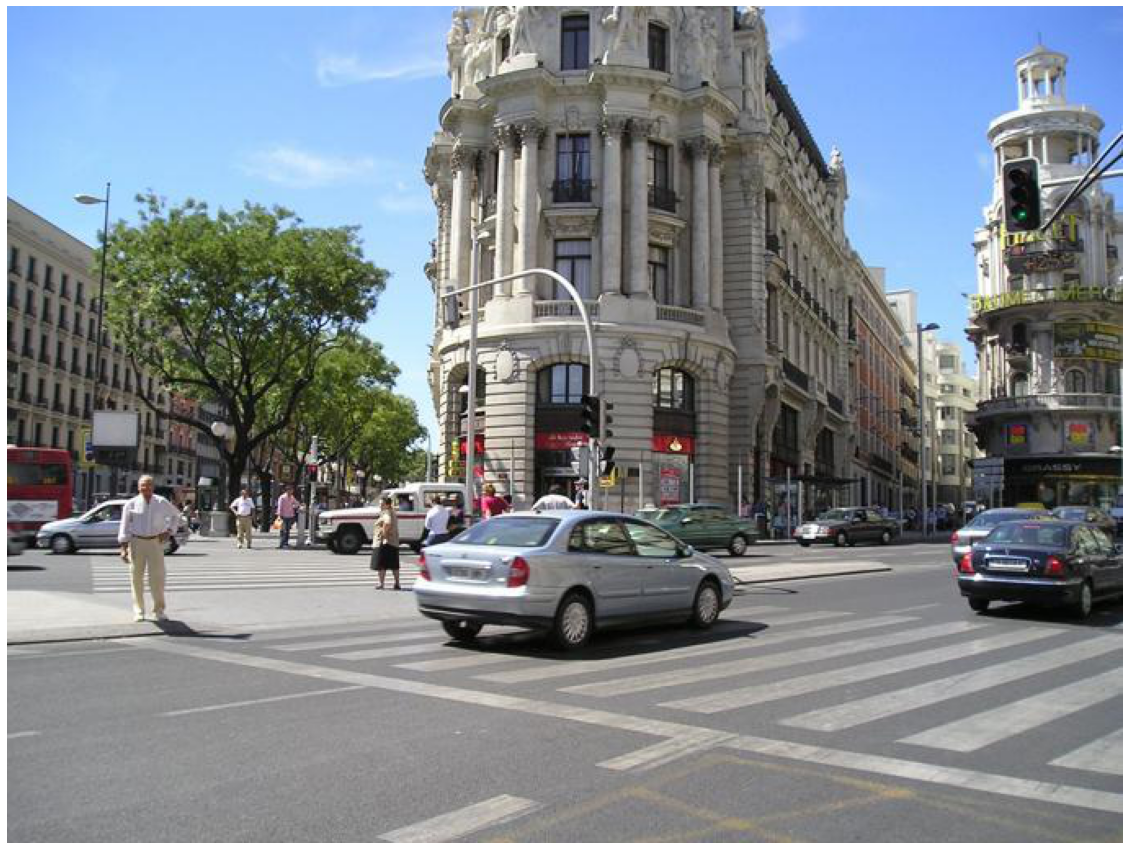

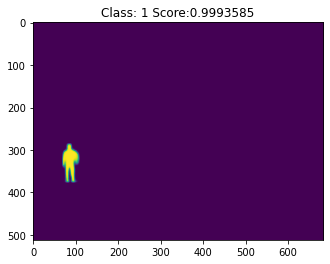

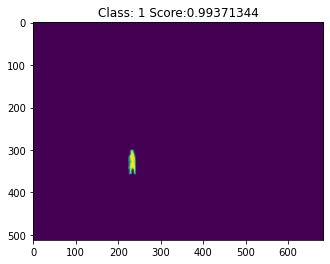

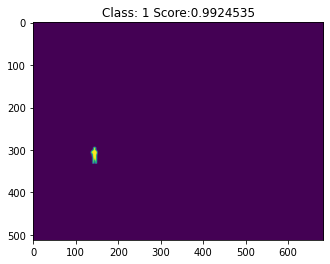

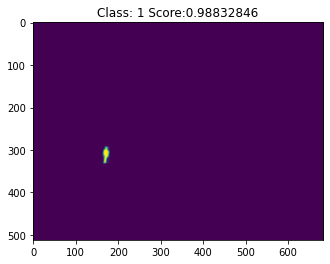

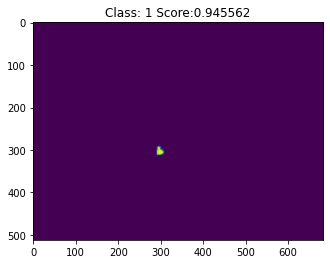

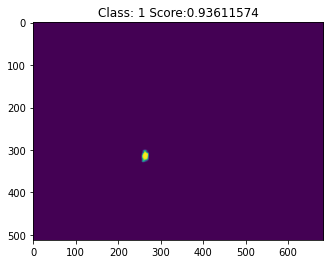

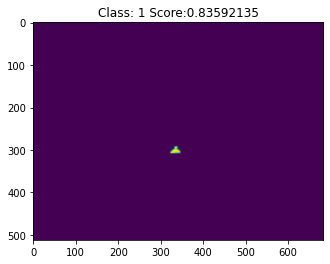

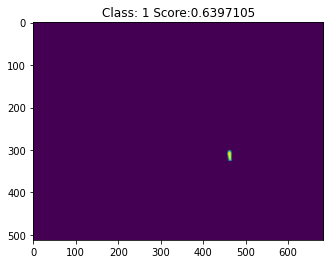

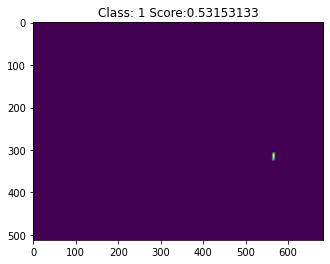

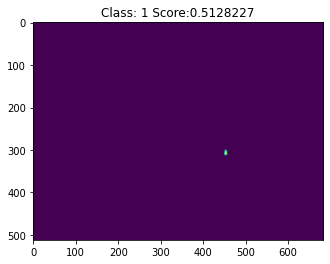

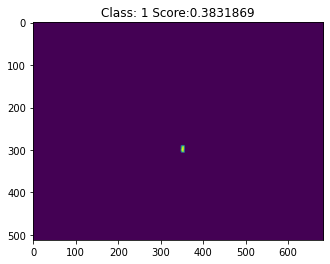

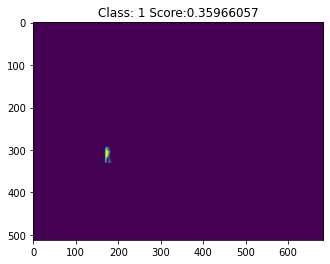

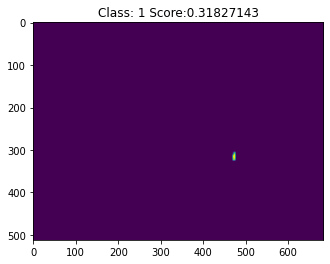

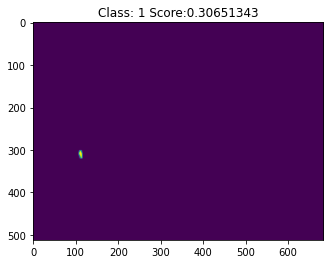

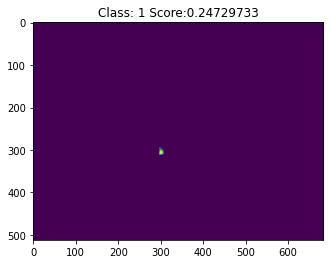

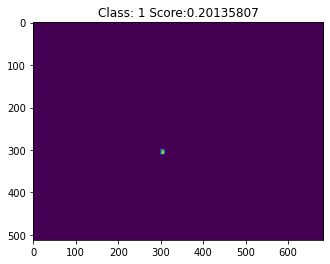

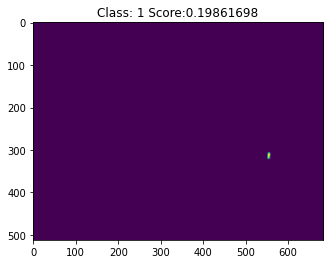

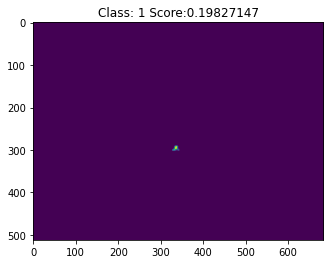

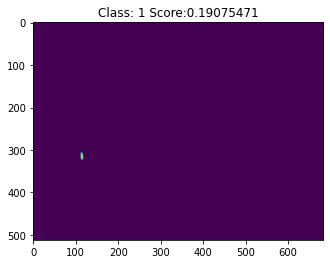

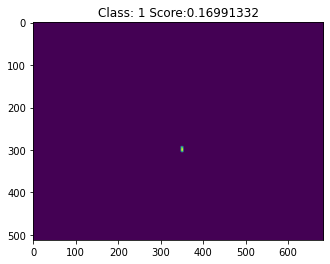

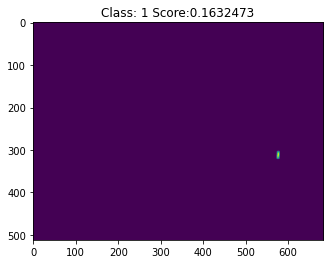

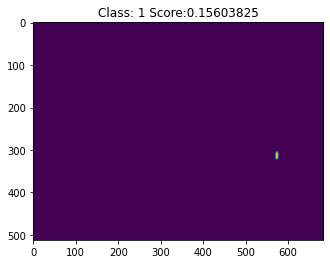

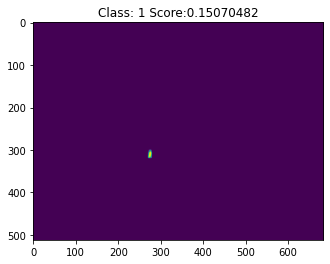

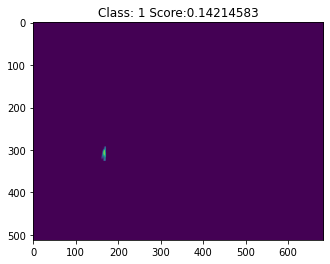

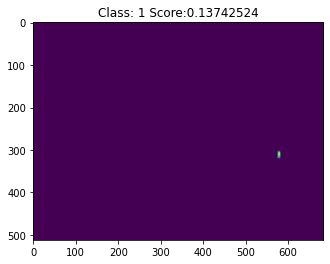

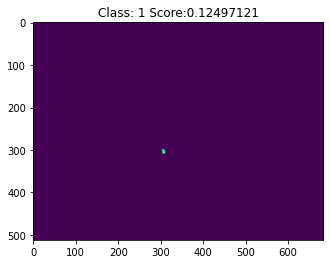

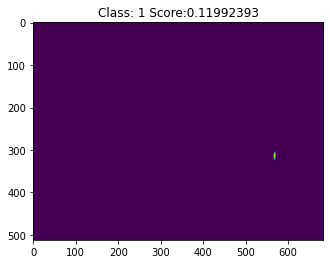

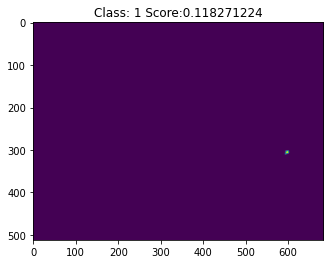

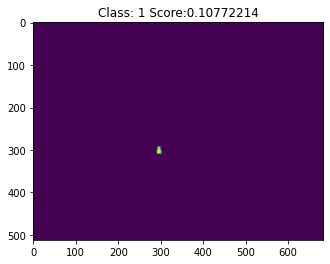

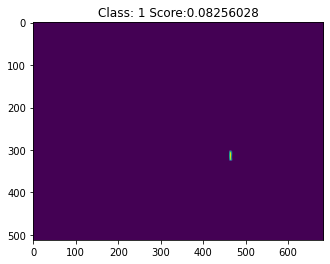

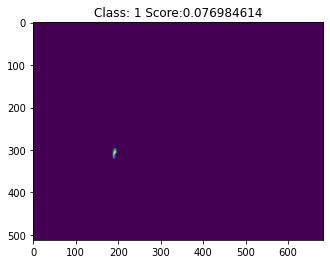

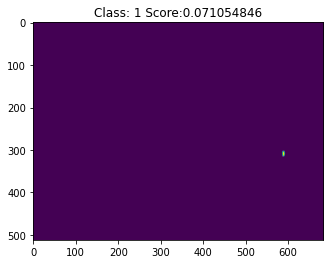

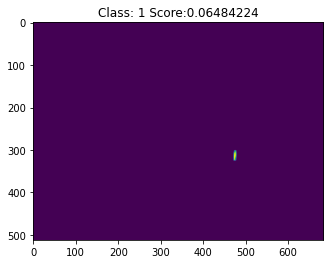

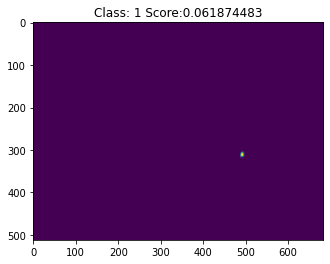

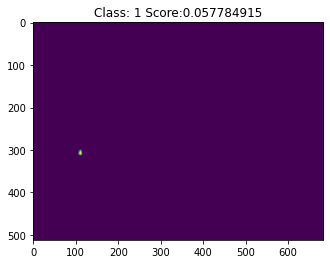

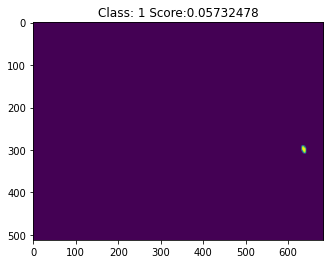

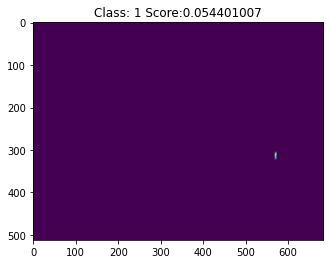

In [18]:
model.eval()
im = dataset_test[0][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])

    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()